In [1]:
# install what  needed
sc.install_pypi_package("matplotlib==3.0.1")
sc.install_pypi_package("Pillow==5.4")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1645546621121_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…



You are using pip version 9.0.1, however version 22.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 22.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [2]:
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np

import urllib.request

import io
import itertools
import sys
import os

tile_url = 'https://s3.amazonaws.com/elevation-tiles-prod/terrarium/{z}/{x}/{y}.png'
data_path = '.'

height_of_tile, width_of_tile = 256, 256

height_of_area, width_of_area = 512, 512
height_of_localization, width_of_localization = 4, 4

number_of_groups = 6

def mercator(lat, lon, zoom):
    ''' Convert latitude, longitude to z/x/y tile coordinate at given zoom.
    '''
    # convert to radians
    x1, y1 = lon * np.pi/180, lat * np.pi/180

    # project to mercator
    x2, y2 = x1, np.log(np.tan(0.25 * np.pi + 0.5 * y1))

    # transform to tile space
    tiles, diameter = 2 ** zoom, 2 * np.pi
    x3, y3 = int(tiles * (x2 + np.pi) / diameter), int(tiles * (np.pi - y2) / diameter)

    return zoom, x3, y3

def generate_tile_coordinates(zoom, lat1, lon1, lat2, lon2):
    ''' Convert geographic bounds into a list of tile coordinates at given zoom.
    '''
    # convert to geographic bounding box
    minlat, minlon = min(lat1, lat2), min(lon1, lon2)
    maxlat, maxlon = max(lat1, lat2), max(lon1, lon2)

    # convert to tile-space bounding box
    _, xmin, ymin = mercator(maxlat, minlon, zoom)
    _, xmax, ymax = mercator(minlat, maxlon, zoom)

    # compute height and width of tile
    height = ymax - ymin + 1
    width = xmax - xmin + 1

    height = int(np.ceil(height / (height_of_area // height_of_tile)) * (height_of_area // height_of_tile))
    width = int(np.ceil(width / (width_of_area // width_of_tile)) * (width_of_area // width_of_tile))

    # generate list of tiles
    xs, ys = range(xmin, xmin + width), range(ymin, ymin + height)
    tiles = [(zoom, x, y) for y, x in itertools.product(ys, xs)]

    height_of_map = height * height_of_tile
    width_of_map = width * width_of_tile

    return height_of_map, width_of_map, tiles

def download_data(tiles_coordinates, verbose=True):
    ''' Download list of tiles and return their names.
    '''
    paths = []
    for z, x, y in tiles_coordinates:
        path = os.path.join(data_path, '{}-{}-{}.png'.format(z, x, y))

        if not os.path.isfile(path):
            response = urllib.request.urlopen(tile_url.format(z=z, x=x, y=y))
            if response.getcode() != 200:
                raise RuntimeError('No such tile: {}'.format((z, x, y)))
            if verbose:
                print('Downloaded', response.url, file=sys.stderr)
            
            
            with io.open(path, 'wb') as file:
                file.write(response.read())
        
        paths.append(path)
    
    return paths

def merge(arrays, height, width):
    return np.vstack([np.hstack(arrays[i*width:(i + 1)*width]) for i in range(height)])

def generate_constraints(data, number_of_groups):
    ''' Generate constraints that will be used for area grouping.
    '''
    return np.linspace(min(data), max(data), number_of_groups + 1)

def group(x):
    ''' Group area.
    '''
    number_of_groups = len(broadcasted_constraints.value) - 1
    for index_of_group in range(number_of_groups):
        lower_constraint = broadcasted_constraints.value[index_of_group]
        upper_constraint = broadcasted_constraints.value[index_of_group + 1]

        if index_of_group != number_of_groups - 1 and lower_constraint <= x and x < upper_constraint:
            return index_of_group
        
        if index_of_group == number_of_groups - 1 and lower_constraint <= x and x <= upper_constraint:
            return index_of_group
    
    return -1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Gdansk
#height_of_map, width_of_map, tiles_coordinates = generate_tile_coordinates(12, 54.372158 + 0.25, 18.638306 + 0.5, 54.372158 - 0.25, 18.638306 - 0.5)
    
# Poland
#height_of_map, width_of_map, tiles_coordinates = generate_tile_coordinates(8, 48, 14, 56, 24)

# Mariana Trench
# height_of_map, width_of_map, tiles_coordinates = generate_tile_coordinates(8, 10, 140, 25, 150)
    
# North and South America
height_of_map, width_of_map, tiles_coordinates = generate_tile_coordinates(5, 83.667, -179.150, -56.538, -34.793)

# Just 1
#height_of_map, width_of_map, tiles_coordinates = generate_tile_coordinates(20, 54.372158 + 0.1, 18.638306 + 0.1, 54.372158 - 0.1, 18.638306 - 0.1)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
paths = download_data(tiles_coordinates)
paths = [paths[i:i+(width_of_map // width_of_tile)] for i in range(0, len(paths), width_of_map // width_of_tile)]
decoded_areas, height_differences = [], []
i_stop, i_step = height_of_map // height_of_tile, height_of_area // height_of_tile
j_stop, j_step = width_of_map // width_of_tile, width_of_area // width_of_tile

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/137/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/138/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/139/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/140/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/141/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/142/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/143/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/144/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/145/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/146/79.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/137/80.png
Downloaded https://s3.amazonaws.com/elevation-tiles-prod/terrarium/8/138/80.png
Downloaded https://s3.amazonaws.com/elev

In [ ]:
for i, j in itertools.product(range(0, i_stop, i_step), range(0, j_stop, j_step)):
    # merge tiles into area
    k_stop, l_stop = height_of_area // height_of_tile, width_of_area // width_of_tile
    splitted_area = [Image.open(paths[i + k][j + l]) for k, l in itertools.product(range(k_stop), range(l_stop))]
    area = merge(splitted_area, height_of_area // height_of_tile, width_of_area // width_of_tile)

    # decode area
    area_rdd = sc.parallelize(area.reshape((area.size // 3, 3)))
    decoded_area_rdd = area_rdd.map(lambda x : x[0]*256 + x[1] + x[2]/256 - 32768)

    decoded_area_rdd.collect()
    decoded_area = np.array(decoded_area_rdd.collect()).reshape((height_of_area, width_of_area))
    decoded_areas.append(decoded_area)

    # convert area to localizations
    vsections = height_of_area // height_of_localization
    hsections = width_of_area // width_of_localization
    localizations = [np.hsplit(row, hsections) for row in np.vsplit(decoded_area, vsections)]
    localizations = np.array(localizations).reshape(
        (decoded_area.size // height_of_localization // width_of_localization,
         height_of_localization*width_of_localization))

    # compute mean height difference
    localizations_rdd = sc.parallelize(localizations)
    localizations_rdd = localizations_rdd.map(lambda x : max(x) - min(x))
    height_differences.append(localizations_rdd.mean())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

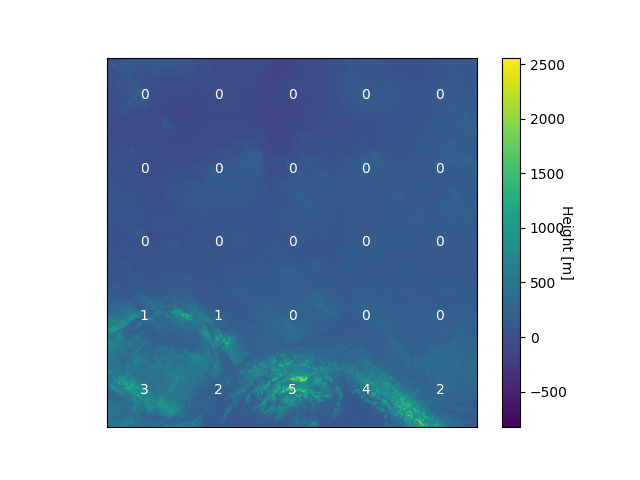

In [7]:
# merge areas
merged_areas = merge(decoded_areas, height_of_map // height_of_area, width_of_map // width_of_area)

# generate groups
constraints = generate_constraints(height_differences, number_of_groups)
broadcasted_constraints = sc.broadcast(constraints)
height_differences_rdd = sc.parallelize(height_differences)
groups = height_differences_rdd.map(group).collect()

# display merged areas
_, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])

im = ax.imshow(merged_areas)
colorbar = ax.figure.colorbar(im, ax=ax)
colorbar.set_label('Height [m]', rotation=270)

for i in range(height_of_map // height_of_area):
    for j in range(width_of_map // width_of_area):
        ax.text(decoded_area.shape[1]*(j + 0.5), decoded_area.shape[0]*(i + 0.5),
            groups[i*(width_of_map // width_of_area) + j], ha='center', va='center', color='w')
plt.savefig('figure.png')

%matplot plt
